In [1]:
pip install pandas geojson folium matplotlib shapely geopandas contextily

Note: you may need to restart the kernel to use updated packages.


# Data Extraction

In [3]:
import os

print(os.listdir(os.getcwd()))

['explore_poi.ipynb', 'road_highlight_map.html', 'road_path_map.html', 'singapore_hawkers_map.html']


In [4]:
import os
# Move up to the parent folder
current_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(current_dir, "data", "singapore\\")
print(data_dir)

gym_file = data_dir + "GymsSGGEOJSON_202501.geojson"
hawker_file = data_dir + "HawkerCentresKML_202501.kml"
hdb_file = data_dir + "HDBExistingBuilding_202501.geojson"
master_land_file = data_dir + "MasterPlan2019LandUselayer_202501.geojson"
master_plan_file = data_dir + "MasterPlan2019PlanningAreaBoundaryNoSea_202501.geojson"
polygon_file = data_dir + "NationalMapPolygon_202501.kml"
park_file = data_dir + "ParkFacilities_202501.geojson"
preschool_file = data_dir + "PreSchoolsLocation_202501.geojson"
road_file = data_dir + "RoadNetwork_202501.kml"
tourist_file = data_dir + "TouristAttractions_202501.geojson"

c:\Users\meiro\Documents\1_project\trade-area-analysis\data\singapore\


### Common Utilities

In [29]:
import pandas as pd

def visualize_data(data_path):
    # Read data
    df = pd.read_csv(data_path, header=0)
    # Clean data 
    df.columns = df.columns.str.lower()

    print(f"there are {len(df)} rows of data")

    display(df.head(5))

    return df

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Enable inline plotting in Jupyter
%matplotlib inline

def visualize_pois(df, df_lon, df_lat, label):
    # Create a GeoDataFrame from the pandas DataFrame
    # Convert lat, lon into Point geometries for the hawker centers
    geometry = [Point(lon, lat) for lon, lat in zip(df_lon, df_lat)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plotting the map with contextily basemap
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the hawker centers (points) in red
    gdf.plot(ax=ax, color="red", marker="o", markersize=50, label=label)

    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Customize the map
    ax.set_title(f"{label} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()

    plt.show()

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon

def visualize_polygon(df, plot_title):
    # Convert the Coordinates column to Shapely Polygon objects
    df['geometry'] = df["coordinates"].apply(lambda x: Polygon(x))

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plot the polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.7)

    # Add labels at the centroid of each polygon
    for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf["polygon_name"]):
        ax.text(x, y, label, fontsize=8, ha="center", color="red")
    
    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Set the title and show the plot
    ax.set_title(f"Polygon Visualization for {plot_title}", fontsize=16)
    plt.show()

### Extract HDB data 

In [49]:
import re
import json
import csv

with open(hdb_file) as f:
    geojson_data = json.load(f)

# Extract column names dynamically from the Description field
# description_sample = geojson_data["features"][0]["properties"]["Description"]
# columns = re.findall(r"<th>(.*?)<\/th>", description_sample)

# Prepare the CSV data
csv_data = []
for feature in geojson_data["features"]:
    # Extract properties
    name = feature["properties"]["Name"]
    description = feature["properties"]["Description"]
    
    # Extract individual attributes from the description HTML
    blk_no = description.split("<th>BLK_NO</th> <td>")[1].split("</td>")[0]
    st_cod = description.split("<th>ST_COD</th> <td>")[1].split("</td>")[0]
    entityid = description.split("<th>ENTITYID</th> <td>")[1].split("</td>")[0]
    postal_cod = description.split("<th>POSTAL_COD</th> <td>")[1].split("</td>")[0]
    inc_crc = description.split("<th>INC_CRC</th> <td>")[1].split("</td>")[0]
    fmel_upd_d = description.split("<th>FMEL_UPD_D</th> <td>")[1].split("</td>")[0]
    
    # Extract geometry
    geometry_type = feature["geometry"]["type"]
    coordinates = feature["geometry"]["coordinates"]
    
    # Append parsed data
    csv_data.append({
        "name": name,
        "block_no": blk_no,
        "street_code": st_cod,
        "entity_id": entityid,
        "postal_code": postal_cod,
        "incremental_checksum": inc_crc,
        "first_merge_last_update_date": fmel_upd_d,
        "geometry_type": geometry_type,
        "coordinates": coordinates,
    })


# Write extracted data to CSV
csv_columns = set().union(*(d.keys() for d in csv_data))
hdb_csv = data_dir + "hdb_202501.csv"
with open(hdb_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_data)

print("data extracted to data folder")

data extracted to data folder


In [58]:
import ast

df_hdb = visualize_data(hdb_csv)
df_hdb["polygon_name"] = df_hdb["block_no"]
# Convert strings to Python objects 
df_hdb['coordinates'] = df_hdb['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure the coordinates are parsed as lists (and flatten if nested)
def flatten_coordinates(coords):
    # Flatten if coordinates are nested
    if isinstance(coords[0], list):  # Check if the coordinates are nested
        return [item for sublist in coords for item in sublist]
    return coords
df_hdb['coordinates'] = df_hdb['coordinates'].apply(flatten_coordinates)

there are 12847 rows of data


,street_code,first_merge_last_update_date,entity_id,coordinates,geometry_type,incremental_checksum,name,block_no,postal_code
0,WOC05L,20230328181025,1991,"[[[103.801697204792, 1.44919018597124, 0.0], [...",Polygon,B93627FDFF3D6313,kml_1,780C,733780
1,BUS09S,20130426120311,6782,"[[[103.750230078901, 1.3589707561372, 0.0], [1...",Polygon,49487496978A23EF,kml_2,373,650373
2,TAS39U,20130426120323,7578,"[[[103.958111068021, 1.35343755833904, 0.0], [...",Polygon,67E2089D8D4D20D0,kml_3,328,520328
3,CHS27B,20130426120328,307,"[[[103.749716688233, 1.39435458145642, 0.0], [...",Polygon,577EE045DEA00FEE,kml_4,771A,681771
4,TEC01D,20130426120321,7332,"[[[103.817313472832, 1.27886768972495, 0.0], [...",Polygon,AF8FF795FF2C87EA,kml_5,3A,91003


In [55]:
visualize_polygon(df_hdb, 'HDB')

TypeError: float() argument must be a string or a real number, not 'list'

### Extract gym data

In [19]:
import re
import json
import csv

with open(gym_file) as f:
    geojson_data = json.load(f)

# Extract column names dynamically from the Description field
description_sample = geojson_data["features"][0]["properties"]["Description"]
columns = re.findall(r"<th>(.*?)<\/th>", description_sample)

# Prepare the CSV data
csv_data = []
for feature in geojson_data["features"]:
    properties = feature["properties"]
    description = properties["Description"]
    
    # Extract values dynamically for each column
    values = re.findall(r"<td>(.*?)<\/td>", description)
    row = dict(zip(columns, values))
    
    # Add geometry coordinates
    row["Longitude"] = feature["geometry"]["coordinates"][0]
    row["Latitude"] = feature["geometry"]["coordinates"][1]
    csv_data.append(row)

# Write to a CSV file
updated_gym_file = data_dir + "gym_202501.csv"
with open(updated_gym_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=columns + ["Longitude", "Latitude"])
    writer.writeheader()
    writer.writerows(csv_data)

print(f"data extracted to data folder")

data extracted to data folder


In [ ]:
df_gym = visualize_data(updated_gym_file)

there are 159 rows of data


,landyaddresspoint,landxaddresspoint,addresspostalcode,addressbuildingname,hyperlink,photourl,addressunitnumber,addressfloornumber,addressstreetname,addressblockhousenumber,description,inc_crc,fmel_upd_d,name,longitude,latitude
0,0,0,78989,NaN,NaN,NaN,NaN,NaN,Tras Street,50,Operating Hours: 7.00am - 10.00am,0E28997B4498C8C3,20160127095840,The Pit,103.844202,1.278114
1,0,0,287992,House J and S,NaN,NaN,NaN,NaN,Turf Club Road,100,"Operating Hours: Monday, Wednesday, Friday: 1...",CAA5268B7BA8784D,20160127095840,The Stable Mixed Martial Arts,103.795898,1.334220
2,0,0,579783,NaN,NaN,NaN,NaN,NaN,Bishan St. 4,5,Facilities: Standard Gymnasium Equipment Opera...,E7A4A38558FA4D85,20160127095840,Bishan ClubFITT Gym,103.850922,1.355283
3,0,0,208568,King George's Building,NaN,NaN,NaN,NaN,King George's Ave,328,NaN,CBB24D03E2FE458E,20160127095840,The Yoga Place,103.862091,1.309922
4,0,0,559022,NaN,NaN,NaN,10,1,Bughley Drive Blk B,45,NaN,51E0C317DBD72838,20160127095840,Sky Fitness - Serangoon Gardens,103.859571,1.360010


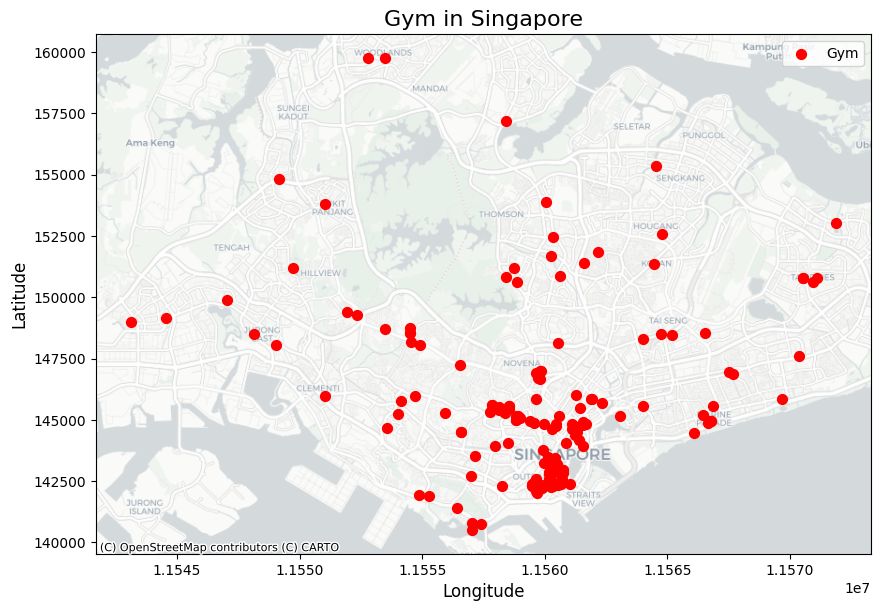

In [27]:
visualize_pois(df_gym, df_gym["longitude"], df_gym["latitude"], 'Gym')

### Extract hawker centre data

In [46]:
# Convert kml file to csv
import xml.etree.ElementTree as ET
import csv

# Parse the KML file
tree = ET.parse(hawker_file)  # Replace with your KML file path
root = tree.getroot()

# Namespace mapping
ns = {
    "kml": "http://www.opengis.net/kml/2.2",
    "gx": "http://www.google.com/kml/ext/2.2",
}

# Extract Placemark data
hawker_data = []
for placemark in root.findall(".//kml:Placemark", ns):
    data = {}
    for simple_data in placemark.findall(".//kml:SimpleData", ns):
        key = simple_data.attrib["name"]
        value = simple_data.text
        data[key] = value
    coordinates = placemark.find(".//kml:coordinates", ns)
    if coordinates is not None:
        data["coordinates"] = coordinates.text.strip()
    hawker_data.append(data)

# Write data to CSV
csv_columns = set().union(*(d.keys() for d in hawker_data))
cleaned_hawker_file = data_dir + "hawker_centre_202501.csv"
with open(cleaned_hawker_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(hawker_data)

print("data extracted to data folder")

data extracted to data folder


In [40]:
df_hawker = visualize_data(cleaned_hawker_file)

there are 125 rows of data


,fmel_upd_d,est_original_completion_date,implementation_date,addressstreetname,name,photourl,hup_completion_date,addressbuildingname,awarded_date,inc_crc,approximate_gfa,landxaddresspoint,info_on_co_locators,addresspostalcode,status,address_myenv,addressblockhousenumber,description,coordinates,landyaddresspoint
0,20221017143612,15/11/2021,1/8/2017,Market Street,Market Street Hawker Centre,NaN,NaN,CapitaSpring,17/7/2017,DB83871D0E006559,NaN,29874.82,hawker centre/commercial space,48940.0,Existing (replacement),NaN,50,New Replacement Centre,"103.850164578087,1.2844248503218,0.0",29650.70
1,20221017143612,8/11/2017,1/1/2016,Woodlands Street 12,Marsiling Mall Hawker Centre,http://www.nea.gov.sg/images/default-source/Ha...,NaN,Marsiling Mall,4/9/2015,67D9A36B865FC1FB,3661.0,22042.51,hawker centre/supermarket/shops,738623.0,Existing (replacement),"Blk 4,Woodlands St 12,Singapore�738623",4,New Replacement Centre,"103.779784899996,1.43353885680037,0.0",46139.03
2,20221017143612,30/3/2022,2/12/2015,Margaret Drive,Margaret Drive Hawker Centre,NaN,NaN,NaN,11/5/2015,C80F89698B7A8757,NaN,24816.70,hawker centre/branch office/supermarket/shops/...,142038.0,Existing (replacement),NaN,38A,New Replacement Centre,"103.804715225285,1.29748567106686,0.0",31094.91
3,20221017143612,22/3/2022,13/8/2018,Sengkang West Avenue,Fernvale Hawker Centre & Market,NaN,NaN,"Fernvale Community Club, Hawker Centre & Market",30/7/2018,E3AB7D1743979E42,NaN,32867.90,hawker centre/market/community club,797650.0,Existing (new),NaN,21,New Centre,"103.877060478847,1.39159232727757,0.0",41500.77
4,20221017143612,29/4/2022,29/8/2018,Punggol Drive,One Punggol Hawker Centre,NaN,NaN,One Punggol,8/8/2018,4780858D968F79C9,NaN,35955.52,hawker centre/Regional Library/Senior Care Cen...,828629.0,Existing (new),NaN,1,New Centre,"103.904805657576,1.40818996870647,0.0",43336.13


In [41]:
# Split the "coordinates" column into "lon", "lat", and "alt", allowing for incomplete splits
df_hawker[["lon", "lat", "alt"]] = df_hawker["coordinates"].str.split(",", expand=True)

# Check if all columns are properly filled (handle missing values if needed)
df_hawker[["lon", "lat", "alt"]] = df_hawker[["lon", "lat", "alt"]].apply(pd.to_numeric, errors='coerce')

display(df_hawker.head(1))

,fmel_upd_d,est_original_completion_date,implementation_date,addressstreetname,name,photourl,hup_completion_date,addressbuildingname,awarded_date,inc_crc,...,addresspostalcode,status,address_myenv,addressblockhousenumber,description,coordinates,landyaddresspoint,lon,lat,alt
0,20221017143612,15/11/2021,1/8/2017,Market Street,Market Street Hawker Centre,NaN,NaN,CapitaSpring,17/7/2017,DB83871D0E006559,...,48940.0,Existing (replacement),NaN,50,New Replacement Centre,"103.850164578087,1.2844248503218,0.0",29650.7,103.850165,1.284425,0.0


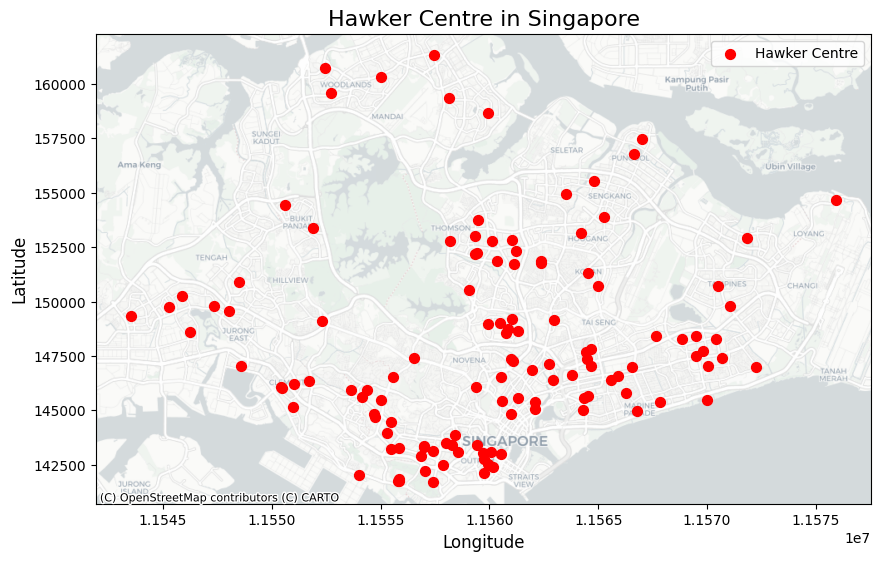

In [43]:
visualize_pois(df_hawker, df_hawker["lon"], df_hawker["lat"], "Hawker Centre")

In [45]:
import folium

# Sample hawker data with lat, lon (you can replace this with your actual dataset)
data = df_hawker [["name", "lat", "lon"]]
# Initialize the map centered at Singapore's location
singapore_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Add markers for each hawker center
for idx, row in data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['name']
    ).add_to(singapore_map)

# Save the map to an HTML file
singapore_map.save("singapore_hawkers_map.html")

# Display map in a Jupyter notebook (if using Jupyter)
singapore_map


### Extract road network

In [ ]:
# Convert kml file to csv
import xml.etree.ElementTree as ET
import csv

# Parse the KML file
tree = ET.parse(road_file)
root = tree.getroot()

# Namespace mapping
ns = {
    "kml": "http://www.opengis.net/kml/2.2",
    "gx": "http://www.google.com/kml/ext/2.2",
}

# Extract Placemark data for the road network
road_network_data = []
for placemark in root.findall(".//kml:Placemark", ns):
    road_name = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='RD_NAME']").text
    road_type = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='RD_TYP_CD']").text
    level_of_road = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='LVL_OF_RD']").text
    coordinates = placemark.find(".//{http://www.opengis.net/kml/2.2}coordinates").text.strip()
    
    # Prepare the extracted data in a structured format
    road_network_data.append({
        'road_name': road_name,
        'road_type': road_type,
        'level_of_road': level_of_road,
        'coordinates': coordinates
    })

# Write extracted data to CSV
csv_columns = set().union(*(d.keys() for d in road_network_data))
cleaned_road_network_file = data_dir + "road_network_202501.csv"
with open(cleaned_road_network_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(road_network_data)

print("data extracted to data folder")

Data extracted to data folder


In [11]:
import pandas as pd

# Read data
df_rn = pd.read_csv(cleaned_road_network_file, header=0)

# Clean data 
df_rn.columns = df_rn.columns.str.lower()

print(f"there are {len(df_rn)} road networks based on URA data")
display(df_rn.head(10))

there are 61822 road networks based on URA data


,coordinates,road_type,road_name,level_of_road
0,"103.872264575107,1.39520697797869,0.0 103.8725...",Slip Road,SENGKANG WEST WAY,At-grade
1,"103.87288738574,1.39534787103477,0.0 103.87296...",Imaginary Line,SENGKANG WEST WAY,At-grade
2,"103.87225257993,1.39509535073548,0.0 103.87226...",Imaginary Line,SENGKANG WEST WAY,At-grade
3,"103.873705682171,1.39510194332845,0.0 103.8737...",Local Access,LORONG TANGGAM,At-grade
4,"103.873751233561,1.39524187566706,0.0 103.8737...",Expunged,LORONG TANGGAM,At-grade
5,"103.873065197779,1.39530511150441,0.0 103.8730...",Slip Road,JALAN KAYU,At-grade
6,"103.865077576035,1.3999412382698,0.0 103.86511...",Local Access,SELETAR WEST FARMWAY 8,At-grade
7,"103.867496600538,1.38996087701559,0.0 103.8680...",Local Access,SELETAR WEST FARMWAY 2,At-grade
8,"103.869949978355,1.39415410335835,0.0 103.8699...",T-Junction,SELETAR WEST FARMWAY 4,At-grade
9,"103.86998336989,1.3947562011979,0.0 103.869984...",Local Access,SELETAR WEST FARMWAY 6,At-grade


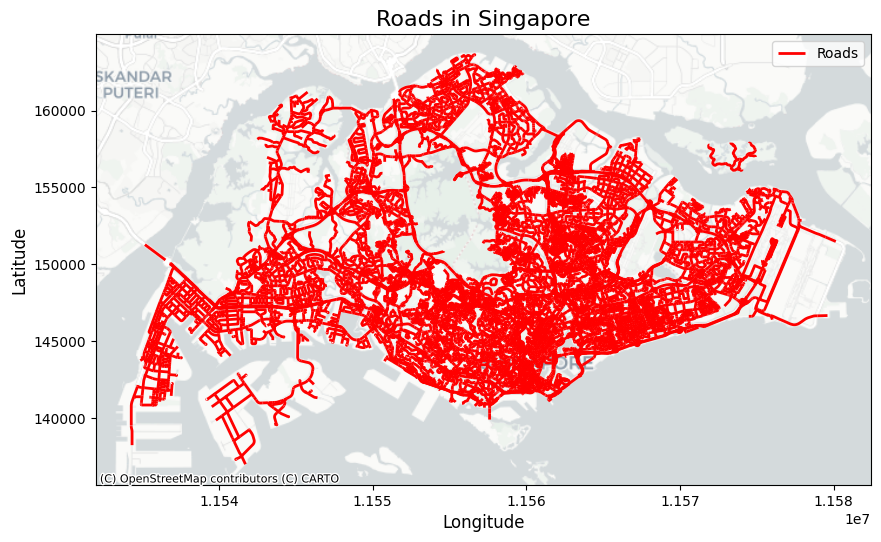

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

# Enable inline plotting in Jupyter
%matplotlib inline

# Function to parse the coordinates into a LineString
def parse_coordinates(coord_string):
    coords = coord_string.split(' ')
    coordinates = [(float(coord.split(',')[0]), float(coord.split(',')[1])) for coord in coords]
    return LineString(coordinates)

# Convert coordinates to Shapely LineString geometries
df_rn['geometry'] = df_rn['coordinates'].apply(parse_coordinates)

# Create a GeoDataFrame from the pandas DataFrame
gdf = gpd.GeoDataFrame(df_rn, geometry='geometry')

# Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857
gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)
gdf = gdf.to_crs(epsg=3857)

# Plotting the map with contextily basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the roads
gdf.plot(ax=ax, color='red', linewidth=2, label='Roads')

# Add basemap using contextily (choose a suitable tile)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Customize the map
ax.set_title("Roads in Singapore", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend()

plt.show()
